In [1]:
# import
!pip install jupyter==1.0.0
!pip install pandas==1.5.3
!pip install geopandas==0.12.2
!pip install matplotlib==3.7.1
!pip install keplergl==0.3.2
!pip install pyrosm==0.6.1
!pip install rtree==1.0.1
!pip install numpy==1.23.5
!pip install shapely==1.8.5
!pip install contextily==1.3.0
!pip install folium==0.14.0
!pip install mapclassify==2.5.0


[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.3.1 -> 23.0.1
[notice] To update, run: pip install --upgrade pip

[notice] 

1. Cargar como GeoDataFrame datos sobre Puntos de Interés de OSM para Madrid

In [15]:
import matplotlib.pyplot as plt

from pyrosm import get_data
from pyrosm import OSM

# Descargar data de la ciudad de Madrid
fp = get_data("Madrid")
print(fp)

# Inicializar OSM parser object
osm = OSM(fp)

/tmp/pyrosm/Madrid.osm.pbf


In [19]:
from pyrosm.config import Conf
print("All available OSM keys", Conf.tags.available)

All available OSM keys ['aerialway', 'aeroway', 'amenity', 'boundary', 'building', 'craft', 'emergency', 'geological', 'highway', 'historic', 'landuse', 'leisure', 'natural', 'office', 'power', 'public_transport', 'railway', 'route', 'place', 'shop', 'tourism', 'waterway']
Available keys related to amenity <pyrosm.config.Tags object at 0x7f5c52f3ae60>


2. Pintar hospitales y farmacias sobre un mapa.

/home/milagros/Documents/UE/BI/GIS_Act1/venv/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/home/milagros/Documents/UE/BI/GIS_Act1/venv/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


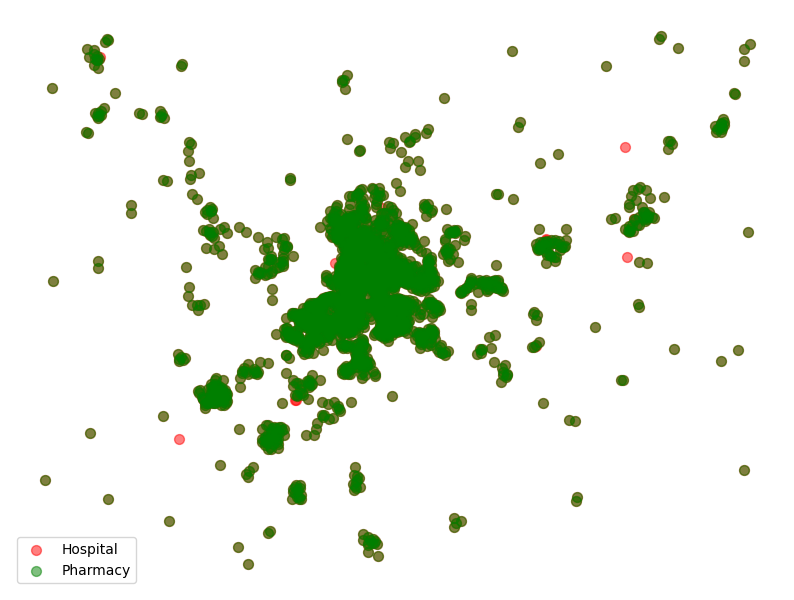

In [9]:
import geopandas as gpd

# Leer Point of Interest usando un custom filter
custom_filter = {"amenity": ["hospital", "pharmacy"]}
pois = osm.get_pois(custom_filter=custom_filter)

# Unir tipos de poi en una sola columna
#pois["amenity"] = pois["amenity"].fillna(' ')
pois["poi_type"] = pois["amenity"]

# Convertir los puntos de interés en un GeoDataFrame de GeoPandas
pois_gdf = gpd.GeoDataFrame(pois, geometry=gpd.points_from_xy(pois.lon, pois.lat))

# Crear un mapa de Madrid con los hospitales y farmacias marcados
ax = pois_gdf.plot(figsize=(10, 10), marker="o", color="red", markersize=50, alpha=0.5, label="Hospital")
pois_gdf[pois_gdf["poi_type"] == "pharmacy"].plot(ax=ax, marker="o", color="green", markersize=50, alpha=0.5, label="Pharmacy")

ax.set_axis_off()
plt.legend()
plt.show()

3. Calcular, para cada hospital, la distancia a la farmacia más cercana.

In [29]:
import numpy as np
from scipy.spatial import distance_matrix

# Eliminar aquellos hospitales o farmacias con coordenadas NaN
pois_clean = pois.dropna(subset=["lat", "lon"])

# Crear un array de coordenadas de hospitales y farmacias
hosp_coords = np.array(pois_clean[pois_clean["poi_type"]=="hospital"][["lat","lon"]])
pharm_coords = np.array(pois_clean[pois_clean["poi_type"]=="pharmacy"][["lat","lon"]])

# Calcular la matriz de distancia euclidiana entre cada par de coordenadas de hospitales y farmacias
distances = distance_matrix(hosp_coords, pharm_coords)

# Encontrar la distancia mínima de cada hospital a una farmacia
min_distances = np.min(distances, axis=1)

# Crear un diccionario que mapea el nombre del hospital a su distancia mínima a una farmacia
hospital_distances = dict(zip(pois_clean[pois_clean["poi_type"]=="hospital"]["name"], min_distances))

# Imprimir las distancias mínimas de cada hospital a una farmacia
for hospital, distance in hospital_distances.items():
    print(f"{hospital}: {distance:.4f} km")

Centro de especialidades Emigrantes: 0.0022 km
Centro de Especialidades: 0.0007 km
Centro de Salud Doctor Trueta: 0.0025 km
Atención médica: 0.0011 km
Centro de salud primaria El Zulema: 0.0148 km
Gerencia SERMAS: 0.0015 km
Fremap: 0.0025 km
Urgencias: 0.0010 km
Centro médico Costa Rica: 0.0020 km
Instituto Anatómico Forense: 0.0058 km
Hospital HM Vallés: 0.0002 km
Hermanas Hospitalarias: 0.0277 km
Centro de Especialidades González Bueno: 0.0017 km
Clínica del Dolor de Madrid: 0.0002 km
Urgencias (Trauma) Severo Ochoa: 0.0037 km
Urgencias (Infantil) Severo Ochoa: 0.0041 km
Consultorio Médico de Camarma de Esteruelas: 0.0401 km
Clínica del Pie Argüelles: 0.0007 km
Clínica Madrid Vascular: 0.0006 km
Cruz Roja Ofic. Territorial Hortaleza-Madrid: 0.0006 km
Hospital Universitario La Moraleja - Ana de Austria: 0.0041 km
Hospital Policlínico La Paloma: 0.0005 km


4. Calcular, para cada hospital, cuántas farmacias se encuentran en menos de 150m

In [26]:
# Crear un diccionario que mapea el nombre del hospital al número de farmacias a menos de 150 metros
hospital_farmacias_cercanas = {}

# Definir la distancia máxima permitida, metros a km
max_distance = 150/1000

# Iterar sobre cada hospital y contar cuántas farmacias están a menos de 150 metros
for i, hospital in enumerate(pois_clean[pois_clean["poi_type"]=="hospital"]["name"]):
    # Obtener la fila correspondiente a este hospital en la matriz de distancias
    distances_to_hospital = distances[i,:]

    # Contar cuántas farmacias están a menos de 150 metros
    num_farmacias_cercanas = len(np.where(distances_to_hospital <= max_distance)[0])

    # Guardar el número de farmacias cercanas para este hospital en el diccionario
    hospital_farmacias_cercanas[hospital] = num_farmacias_cercanas

# Imprimir el número de farmacias cercanas para cada hospital
for hospital, num_farmacias in hospital_farmacias_cercanas.items():
    print(f"{hospital}: {num_farmacias}")


Centro de especialidades Emigrantes: 1830
Centro de Especialidades: 255
Centro de Salud Doctor Trueta: 913
Atención médica: 265
Centro de salud primaria El Zulema: 103
Gerencia SERMAS: 1895
Fremap: 43
Urgencias: 254
Centro médico Costa Rica: 1914
Instituto Anatómico Forense: 1917
Hospital HM Vallés: 111
Hermanas Hospitalarias: 182
Centro de Especialidades González Bueno: 1877
Clínica del Dolor de Madrid: 1931
Urgencias (Trauma) Severo Ochoa: 1318
Urgencias (Infantil) Severo Ochoa: 1314
Consultorio Médico de Camarma de Esteruelas: 109
Clínica del Pie Argüelles: 1925
Clínica Madrid Vascular: 1953
Cruz Roja Ofic. Territorial Hortaleza-Madrid: 1811
Hospital Universitario La Moraleja - Ana de Austria: 1834
Hospital Policlínico La Paloma: 276


TAREA 2

1. Cargar como GeoDataFrame datos las geometrías de las secciones censales de Madrid

In [12]:
import geopandas as gpd

file = './seccionado_2022/España_Seccionado2022_ETRS89H30/SECC_CE_20220101.shp'
secciones_censales = gpd.read_file(file)

# Filtrar las secciones censales para la Comunidad de Madrid
secciones_censales_cm = secciones_censales[secciones_censales['NCA'] == 'Comunidad de Madrid']
secciones_censales_cm


,CUSEC,CUMUN,CSEC,CDIS,CMUN,CPRO,CCA,CUDIS,CLAU2,NPRO,NCA,CNUT0,CNUT1,CNUT2,CNUT3,NMUN,geometry
16501,2800101001,28001,001,01,001,28,13,2800101,28001,Madrid,Comunidad de Madrid,ES,3,0,0,"Acebeda, La","POLYGON ((446007.875 4552347.977, 446133.725 4..."
16502,2800201001,28002,001,01,002,28,13,2800201,28002,Madrid,Comunidad de Madrid,ES,3,0,0,Ajalvir,"POLYGON ((460243.759 4487756.134, 460322.396 4..."
16503,2800201002,28002,002,01,002,28,13,2800201,28002,Madrid,Comunidad de Madrid,ES,3,0,0,Ajalvir,"POLYGON ((457392.506 4486262.150, 457391.587 4..."
16504,2800301001,28003,001,01,003,28,13,2800301,28003,Madrid,Comunidad de Madrid,ES,3,0,0,Alameda del Valle,"POLYGON ((431875.209 4526664.888, 431821.469 4..."
16505,2800401001,28004,001,01,004,28,13,2800401,28004,Madrid,Comunidad de Madrid,ES,3,0,0,"Álamo, El","POLYGON ((416737.550 4456242.216, 416918.526 4..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36340,2817201007,28172,007,01,172,28,13,2817201,28172,Madrid,Comunidad de Madrid,ES,3,0,0,Villalbilla,"POLYGON ((469034.152 4475866.485, 469065.934 4..."
36341,2817201008,28172,008,01,172,28,13,2817201,28172,Madrid,Comunidad de Madrid,ES,3,0,0,Villalbilla,"POLYGON ((475509.080 4476078.114, 475509.080 4..."
36342,2817201005,28172,005,01,172,28,13,2817201,28172,Madrid,Comunidad de Madrid,ES,3,0,0,Villalbilla,"POLYGON ((475383.492 4475406.332, 475582.105 4..."
36378,2800505027,28005,027,05,005,28,13,2800505,28005,Madrid,Comunidad de Madrid,ES,3,0,0,Alcalá de Henares,"POLYGON ((469624.977 4482150.090, 469627.413 4..."


In [13]:
import geopandas as gpd




# Cargar el GeoDataFrame de POIs
pois_madrid_2 = gpd.read_file('content/retail/retail-madrid.shp')

# Cargar el GeoDataFrame de secciones censales
secciones_censales_2 = gpd.read_file('content/temp_folder/SECC_CE_20200101.shp')

print(pois_madrid_2.crs)
print(secciones_censales_2.crs)

# Realizar la operación de unión espacial
#pois_con_seccion2 = gpd.sjoin(pois_madrid_2, secciones_censales_2, op='within')

DriverError: Unable to open content/retail/retail-madrid.shx or content/retail/retail-madrid.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

In [19]:
import geopandas as gpd
import zipfile

#zip_ref = zipfile.ZipFile('seccionado_2020.zip', 'r')
#zip_ref.extractall('temp_folder')
#zip_ref.close()
file = './seccionado_2022/España_Seccionado2022_ETRS89H30/SECC_CE_20220101.shp'
sc_2 = './content/temp_folder/SECC_CE_20220101.shp'
#gdf_sc = gpd.read_file(file)

madrid2 = './content/retail/retail-madrid.shp'
retail = gpd.read_file(madrid2)


#print(gdf_sc.crs)
#print(retail.crs)

#gdf_sc = gdf_sc.to_crs(epsg=3857)
#joined_gdf = gpd.sjoin(retail, gdf_sc, op='within')

DriverError: Unable to open ./content/retail/retail-madrid.shx or ./content/retail/retail-madrid.SHX. Set SHAPE_RESTORE_SHX config option to YES to restore or create it.

2. Asignar a cada POI su sección censal

In [1]:
import geopandas as gpd
import pyrosm
# Load the OSM data into a GeoDataFrame
# Cargar el archivo OSM PBF como objeto pyrosm
osm_madrid = pyrosm.OSM("madrid-latest.osm.pbf")
#osm_gdf = gpd.read_file("madrid-latest.osm.pbf", layer="points")

# Extract points of interest (hospitals and pharmacies)
tags = {"amenity": ["hospital", "pharmacy"]}
#pois_madrid = osm_madrid.get_pois_by_tags(tags)
pois_madrid = osm_madrid.get_pois()

# Convert the POIs to a GeoDataFrame
pois_gdf = gpd.GeoDataFrame.from_features(pois_madrid)
pois_gdf
# Load the shapefile data into a GeoDataFrame
#shapefile_gdf = secciones_censales_cm #gpd.read_file("my_shapefile.shp")

# Perform a spatial join between the two GeoDataFrames
#joined_gdf = gpd.sjoin(osm_gdf, shapefile_gdf, how="left", op="within")
# Perform a spatial join between the two GeoDataFrames
#joined_gdf = gpd.sjoin(pois_gdf, shapefile_gdf, how="left", op="within")

# Print the resulting GeoDataFrame
#print(joined_gdf.head())



/home/milagros/Documents/UE/BI/GIS_Act1/venv/lib/python3.10/site-packages/pyrosm/pyrosm.py:576: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  gdf = get_poi_data(
/home/milagros/Documents/UE/BI/GIS_Act1/venv/lib/python3.10/site-packages/geopandas/array.py:1406: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 (the single non-null crs provided).
  warnings.warn(


,geometry,lat,tags,timestamp,version,changeset,lon,id,addr:city,addr:country,...,museum,tourism,osm_type,bbq,landuse,taxi,gift,swimming_pool,water,zoo
0,POINT (-3.73285 40.39959),40.399590,"{""brand"":""Repsol"",""brand:wikidata"":""Q174747"",""...",1674900645,9,0.0,-3.732854,21812709,None,None,...,None,None,node,None,None,None,None,None,None,None
1,POINT (-3.70237 40.41154),40.411545,None,1648843622,5,0.0,-3.702375,21947483,Madrid,ES,...,None,apartment,node,None,None,None,None,None,None,None
2,POINT (-3.74325 40.37354),40.373535,None,1667501214,11,0.0,-3.743247,22554715,None,None,...,None,None,node,None,None,None,None,None,None,None
3,POINT (-3.79481 40.39433),40.394325,None,1668886649,6,0.0,-3.794810,25911220,None,None,...,None,None,node,None,None,None,None,None,None,None
4,POINT (-3.79491 40.39407),40.394066,"{""created_by"":""JOSM""}",1171490432,1,0.0,-3.794909,25911223,None,None,...,None,None,node,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88638,"POLYGON ((-3.53046 40.33615, -3.53087 40.33601...",NaN,"{""type"":""multipolygon""}",1673253143,1,0.0,NaN,107905048833,None,None,...,None,None,relation,None,None,None,None,None,None,None
88639,"POLYGON ((-3.53046 40.33615, -3.53028 40.33620...",NaN,"{""brand"":""Kiabi"",""brand:wikidata"":""Q3196299"",""...",1673253143,1,0.0,NaN,107920149848,None,None,...,None,None,relation,None,None,None,None,None,None,None
88640,"POLYGON ((-3.42447 40.13663, -3.42447 40.13664...",NaN,"{""alt_name"":""Castillo de los Condes"",""castle_t...",1676231941,1,0.0,NaN,416143618,None,None,...,None,attraction,relation,None,None,None,None,None,None,None
88641,"POLYGON ((-3.42785 40.13885, -3.42737 40.13884...",NaN,"{""name:en"":""Convent of the Poor Clare Sisters""...",1676231941,1,0.0,NaN,431613344,None,None,...,None,None,relation,None,None,None,None,None,None,None


In [ ]:
import pyrosm

# Cargar el archivo OSM PBF como objeto pyrosm
osm_madrid = pyrosm.OSM("madrid-latest.osm.pbf")

# Obtener los datos de puntos de interés (POIs)
pois_madrid = osm_madrid.get_pois()

# Convertir los POIs en un GeoDataFrame
pois_madrid_gdf = pyrosm.get_geodataframe(pois_madrid)


# Load the OSM data into a Pandas DataFrame
#osm_data = pyrosm.OSM("madrid-latest.osm.pbf")
df = osm_madrid.to_pandas()

# Filter the data to include only the desired features (e.g. hospitals and pharmacies)
pois = df[df["boundary"].isin(["hospital", "pharmacy"])]

# Convert the DataFrame to a GeoDataFrame, specifying the geometry column as "geometry"
gdf = gpd.GeoDataFrame(pois, geometry="geometry")

# Assign the CRS (coordinate reference system) of the GeoDataFrame
gdf.crs = "EPSG:4326"

# Spatially join the GeoDataFrame with the census sections data to assign each POI to a section
poi_sections = gpd.sjoin(gdf, secciones_censales_cm, how="left", op="within")
poi_sections

# Realizar la operación de unión espacial
#pois_con_seccion = gpd.sjoin(pois_madrid, secciones_censales_cm, op='within')
#pois_con_seccion

/home/milagros/Documents/UE/BI/GIS_Act1/venv/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


3. Agrupar y sacar conteos para cada SC. ¿donde destacan bares y restaurantes vs donde destaca alimentación?

4. Visualizar en mapas

TAREA 3

1. Añadir información sobre la renta disponible media anual de cada sección censal

2. Asignar a cada sección censal su renta media

3. Entrenar un modelo supervisado que prediga la renta disponible en función de los datos de OSM

4. Evaluar el modelo, interpretar y visualizar